<a href="https://colab.research.google.com/github/scgupta/yearn2learn/blob/master/ml/pandas/pandas_apply_fn_on_dataframe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# How to efficently apply a function to Pandas Dataframe rows

Blog post: [Best Way to Apply a Function to Each Row in Pandas DataFrame](https://medium.com/@scgupta/apply-function-to-pandas-dataframe-rows-76df74165ee4)

## Setup

Install needed libs and import modules.

In [1]:
!pip install \
    datetime pandas numpy \
    faker line_profiler perfplot \
    numba pandarallel dask[dataframe] swifter \
    &> /dev/null

In [2]:
%load_ext line_profiler

In [3]:
import numpy as np
import pandas as pd
import datetime
import perfplot

from faker import Faker

In [4]:
!lscpu

Architecture:        x86_64
CPU op-mode(s):      32-bit, 64-bit
Byte Order:          Little Endian
CPU(s):              2
On-line CPU(s) list: 0,1
Thread(s) per core:  2
Core(s) per socket:  1
Socket(s):           1
NUMA node(s):        1
Vendor ID:           GenuineIntel
CPU family:          6
Model:               63
Model name:          Intel(R) Xeon(R) CPU @ 2.30GHz
Stepping:            0
CPU MHz:             2300.000
BogoMIPS:            4600.00
Hypervisor vendor:   KVM
Virtualization type: full
L1d cache:           32K
L1i cache:           32K
L2 cache:            256K
L3 cache:            46080K
NUMA node0 CPU(s):   0,1
Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm invpcid_single ssbd ibrs 

In [5]:
import multiprocessing

CPU_COUNT = multiprocessing.cpu_count()

CPU_COUNT

2

## Test Data

In real life, this data would be read from a CSV file or a data store. But for this tutorial, generating test data to keep it simple.

In [6]:
def generate_test_data(size: int, days: int = 30):
  fake = Faker()
  Faker.seed(42)

  PRIORITIES = {
    0: 'HIGH',
    1: 'MEDIUM',
    2: 'LOW'
  }

  return pd.DataFrame({
    'task_name': [
      f'Task {i + 1}'
      for i in range(size)
    ],
    'due_date': [
      fake.date_between(start_date='today', end_date=f'+{days}d')
      for _ in range(size)
    ],
    'priority': [
      PRIORITIES[fake.pyint(min_value=0, max_value=(len(PRIORITIES) - 1))]
      for i in range(size)
    ]
  })


In [7]:
# Try generate_test_data
tmp_df = generate_test_data(10, 5)
tmp_df.info()
tmp_df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   task_name  10 non-null     object
 1   due_date   10 non-null     object
 2   priority   10 non-null     object
dtypes: object(3)
memory usage: 368.0+ bytes


,task_name,due_date,priority
0,Task 1,2020-10-29,LOW
1,Task 2,2020-10-26,LOW
2,Task 3,2020-10-26,LOW
3,Task 4,2020-10-30,HIGH
4,Task 5,2020-10-27,LOW
5,Task 6,2020-10-27,MEDIUM
6,Task 7,2020-10-27,HIGH
7,Task 8,2020-10-26,HIGH
8,Task 9,2020-10-30,HIGH
9,Task 10,2020-10-26,HIGH


In [8]:
tmp_df['task_name'].loc[0]

'Task 1'

In [9]:
tmp_df['due_date'].loc[0]
# pd.to_datetime(tmp_df['due_date']).dt.date.loc[0]

datetime.date(2020, 10, 29)

In [10]:
tmp_df['priority'].loc[0]

'LOW'

### Generate Test Dataset

In [11]:
# Generate a million rows. Use sample from it to create various size data sets
# Will take some time as Faker will be called sequencially.
test_data_set = generate_test_data(1000000, 90)

In [12]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-27,HIGH
1,Task 2,2020-11-05,LOW
2,Task 3,2020-10-28,LOW
3,Task 4,2021-01-05,MEDIUM
4,Task 5,2020-11-21,HIGH


In [13]:
def test_data_sample(size: int):
  return test_data_set.sample(n=size).copy().reset_index(drop=True)

In [14]:
# Test sample of size 10
test_data_sample(10).head(5)

,task_name,due_date,priority
0,Task 13852,2020-11-05,LOW
1,Task 937621,2021-01-03,HIGH
2,Task 263181,2021-01-06,LOW
3,Task 924953,2020-11-13,LOW
4,Task 578619,2020-11-28,MEDIUM


In [15]:
test_data_set.head(5)

,task_name,due_date,priority
0,Task 1,2020-12-27,HIGH
1,Task 2,2020-11-05,LOW
2,Task 3,2020-10-28,LOW
3,Task 4,2021-01-05,MEDIUM
4,Task 5,2020-11-21,HIGH


## Optimize DataFrame Storage

Compacting the data not only saves space, but also speeds up the processing. Two common opportunities are:

- Converting timestamp strings or datetime to [datetime64](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)
- Converting strings of enum types to [Categorical](https://pandas.pydata.org/pandas-docs/stable/user_guide/categorical.html) data type

For fair comparision, compression test data to max extent possible.

In [16]:
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   task_name  1000000 non-null  object
 1   due_date   1000000 non-null  object
 2   priority   1000000 non-null  object
dtypes: object(3)
memory usage: 22.9+ MB


In [17]:
priority_dtype = pd.api.types.CategoricalDtype(
  categories=['LOW', 'MEDIUM', 'HIGH'],
  ordered=True
)

In [18]:
priority_map = dict(enumerate(pd.Series(['']).astype(priority_dtype).cat.categories))
priority_map

{0: 'LOW', 1: 'MEDIUM', 2: 'HIGH'}

In [19]:
test_data_set['priority'] = test_data_set['priority'].astype(priority_dtype)
test_data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 3 columns):
 #   Column     Non-Null Count    Dtype   
---  ------     --------------    -----   
 0   task_name  1000000 non-null  object  
 1   due_date   1000000 non-null  object  
 2   priority   1000000 non-null  category
dtypes: category(1), object(2)
memory usage: 16.2+ MB


In [20]:
test_data_set['priority'].loc[0]

'HIGH'

Using category for priority reduced the memory usage by ~30%.

## Optimize DataFrame Processing Time

### The Eisenhower Method

Decide about action needed using [Eisenhower method](https://en.wikipedia.org/wiki/Time_management#The_Eisenhower_Method):

| Important | Urgent    | Binary | Int | Action   |
| --------- | --------- | :----: | :-: | -------- |
| True (1)  | True (1)  |   11   |  3  | DO       |
| True (1)  | False (0) |   10   |  2  | SCHEDULE |
| False (0) | True (1)  |   01   |  1  | DELEGATE |
| False (0) | False (0) |   00   |  0  | DELETE   |

In [21]:
action_dtype = pd.api.types.CategoricalDtype(
  categories=['DELETE', 'DELEGATE', 'SCHEDULE', 'DO'],
  ordered=True
)

In [22]:
action_map = dict(enumerate(pd.Series(['']).astype(action_dtype).cat.categories))
action_map

{0: 'DELETE', 1: 'DELEGATE', 2: 'SCHEDULE', 3: 'DO'}

In [23]:
def eisenhower_action(is_important: bool, is_urgent: bool) -> int:
  return 2 * is_important + is_urgent

def eisenhower_action_str(is_important: bool, is_urgent: bool) -> str:
  return action_map[eisenhower_action(is_important, is_urgent)]

In [24]:
# Let's say anything due by tomorrow is Urgent
cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

In [25]:
# Test compute_eisenhower_action

eisenhower_action_str(
  test_data_set.loc[0].priority == 'HIGH',
  test_data_set.loc[0].due_date <= cutoff_date
)

'SCHEDULE'

In [26]:
# Work with a smaller data set to try each alternative
data_sample = test_data_sample(100000)

### Method 1: Loop Over All Rows of a DataFrame

In [27]:
def loop_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)

  result = []
  for i in range(len(df)):
    row = df.iloc[i]
    result.append(
      eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    )

  return pd.Series(result)

In [28]:
%timeit data_sample['action_loop'] = loop_impl(data_sample)

1 loop, best of 3: 37.9 s per loop


In [29]:
%lprun -f loop_impl  loop_impl(test_data_sample(100))

### Method 2: Iterate over rows with `iterrows` Function

In [30]:
def iterrows_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for index, row in df.iterrows()
  )

In [31]:
%timeit data_sample['action_iterrow'] = iterrows_impl(data_sample)

1 loop, best of 3: 9.25 s per loop


### Method 3: Iterate over rows with `itertuples` Function

In [32]:
def itertuples_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series(
    eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date)
    for row in df.itertuples()
  )

In [33]:
%timeit data_sample['action_itertuples'] = itertuples_impl(data_sample)

10 loops, best of 3: 188 ms per loop


### Method 4: Pandas `apply` Function to Every Row

In [34]:
def apply_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

In [35]:
%timeit data_sample['action_impl'] = apply_impl(data_sample)

1 loop, best of 3: 1.72 s per loop


### Method 5: List Comprehension

In [36]:
def list_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return pd.Series([
    eisenhower_action(priority == 'HIGH', due_date <= cutoff_date)
    for (priority, due_date) in zip(df['priority'], df['due_date'])
  ])

In [37]:
%timeit data_sample['action_list'] = list_impl(data_sample)

10 loops, best of 3: 71.1 ms per loop


### Method 6: *Vectorization*

In [38]:
def vec_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return (2*(df['priority'] == 'HIGH') + (df['due_date'] <= cutoff_date))

In [39]:
%timeit data_sample['action_vec'] = vec_impl(data_sample)

10 loops, best of 3: 20.3 ms per loop


### Method 7: NumPy `vectorize` function

Ref.: [From Python to NumPy](https://www.labri.fr/perso/nrougier/from-python-to-numpy/)

In [40]:
def np_vec_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return np.vectorize(eisenhower_action)(df['priority'] == 'HIGH', df['due_date'] <= cutoff_date)

In [41]:
%timeit data_sample['action_np_vec'] = np_vec_impl(data_sample)

10 loops, best of 3: 36.2 ms per loop


### Method 8: Numba Decorators

[Numba](https://numba.pydata.org) is commonly used to speed up applying mathmatical functions.

In [42]:
import numba

@numba.vectorize
def numba_eisenhower_action(is_important: bool, is_urgent: bool) -> int:
  return 2 * is_important + is_urgent

def numba_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return numba_eisenhower_action(
    (df['priority'] == 'HIGH').to_numpy(),
    (df['due_date'] <= cutoff_date).to_numpy()
  )

In [43]:
%timeit data_sample['action_numba'] = numba_impl(data_sample)

The slowest run took 9.48 times longer than the fastest. This could mean that an intermediate result is being cached.
100 loops, best of 3: 18.7 ms per loop


### Method 9: Multiprocessing with `pandarallel` 

In [44]:
from pandarallel import pandarallel

pandarallel.initialize()

def pandarallel_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.parallel_apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [45]:
%timeit data_sample['action_pandarallel'] = pandarallel_impl(data_sample)

1 loop, best of 3: 2.04 s per loop


### Method 10: Parallelize with Dask

[Dask](https://dask.org) is a parallel computing library that supports scaling up NumPy, Pandas, Scikit-learn and many other Python libraries.


In [46]:
import dask.dataframe as dd

def dask_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return dd.from_pandas(df, npartitions=CPU_COUNT).apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1,
    meta=(int)
  ).compute()

In [47]:
%timeit data_sample['action_dask'] = dask_impl(data_sample)

1 loop, best of 3: 2.05 s per loop


### Method 11: Opportunistic Parallelization with Swifter

[Swifter](https://github.com/jmcarpenter2/swifter) automatically decides which is faster: to use dask parallel processing or a simple pandas apply.

In [48]:
import swifter

def swifter_impl(df):
  cutoff_date = datetime.date.today() + datetime.timedelta(days=2)
  return df.swifter.apply(
    lambda row: eisenhower_action(row.priority == 'HIGH', row.due_date <= cutoff_date),
    axis=1
  )

In [49]:
%timeit data_sample['action_swifter'] = swifter_impl(data_sample)

10 loops, best of 3: 26.1 ms per loop


### Test Correctness

In [50]:
data_sample[data_sample['action_loop'] != data_sample['action_iterrow']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [51]:
data_sample[data_sample['action_loop'] != data_sample['action_itertuples']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [52]:
data_sample[data_sample['action_loop'] != data_sample['action_impl']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [53]:
data_sample[data_sample['action_loop'] != data_sample['action_list']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [54]:
data_sample[data_sample['action_loop'] != data_sample['action_vec']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [55]:
data_sample[data_sample['action_loop'] != data_sample['action_np_vec']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [56]:
data_sample[data_sample['action_loop'] != data_sample['action_numba']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [57]:
data_sample[data_sample['action_loop'] != data_sample['action_pandarallel']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [58]:
data_sample[data_sample['action_loop'] != data_sample['action_dask']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


In [59]:
data_sample[data_sample['action_loop'] != data_sample['action_swifter']]

,task_name,due_date,priority,action_loop,action_iterrow,action_itertuples,action_impl,action_list,action_vec,action_np_vec,action_numba,action_pandarallel,action_dask,action_swifter


## Plot Performance Over DataFrame Size


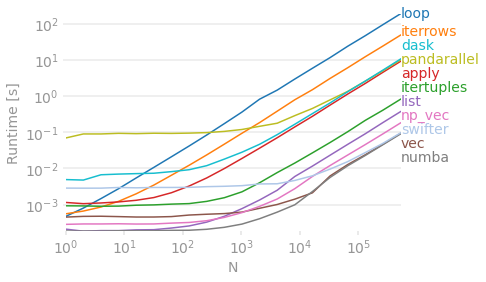

In [60]:
kernels = [
  loop_impl,
  iterrows_impl,
  itertuples_impl,
  apply_impl,
  list_impl,
  vec_impl,
  np_vec_impl,
  numba_impl,
  pandarallel_impl,
  dask_impl,
  swifter_impl
]

labels = [str(k.__name__)[:-5] for k in kernels]

perfplot.show(
  setup=lambda n: test_data_sample(n),
  kernels=kernels,
  labels=labels,
  n_range=[2**k for k in range(20)],
  xlabel='N',
  logx=True,
  logy=True,
  #equality_check=None
)

## Summary

Performance Comparision:

| Method             | CPU Time (s) |
| ------------------ | -----------: | 
| Python Loop        |      37.9000 |
| Pandas iterrow()   |       9.2500 |
| Pandas apply()     |       1.7200 |
| Pandas itertuples()|       0.1880 |
| List Comprehension |       0.0711 |
| NumPy vectorize()  |       0.0362 |
| Vectorization      |       0.0203 |
| ------------------ | ------------ | 
| Numba              |       0.0187 |
| Pandarallel        |       2.0400 |
| Dask               |       2.0500 |
| Swifter            |       0.0261 |